# Molecular Spectral Latent Modelling
- Jan Andrzejewski
- Marcel Wilanowicz

In [2]:
import random
import matplotlib.pyplot as plt
import glob
import os
import pandas as pd
import selfies as sf
import re
import csv
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from scipy.signal import find_peaks
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display

## 1. Loading and analyzing the dataset structure

Dataset taken from: https://zenodo.org/records/11611178

In [2]:
##### DON'T RUN THIS CELL AGAIN #####
''' A random sample of k=10 files was loaded for preliminary analysis, 
which corresponds to approximately 4% of the entire collection.'''

# Directory containing full dataset
DATA_DIR = "multimodal_spectroscopic_dataset"

# List of all .parquet files in DATA_DIR directory
paths = sorted(glob.glob(os.path.join(DATA_DIR, "*.parquet"))) 
print(f"Found {len(paths)} .parquet files in total.")

# Random sample of k=10 files from the list "paths"
k = 10
sample_paths = random.sample(paths, k=k)

dfs = [] # DataFrames list
rows_total = 0 # Total rows counter

# Iterate over .parquet files in the sample
for p in sample_paths:
    df = pd.read_parquet(p) # Load .parquet file into DataFrame
    dfs.append(df) # Append DataFrame to the list
    print(os.path.basename(p), "->", len(df), "records") # Print file name and number of records in it
    rows_total += len(df) # Update total rows counter

data = pd.concat(dfs, ignore_index=True) # Concatenate all DataFrames into a single DataFrame "data"

print("-" * 50)
print(f"Loaded {rows_total:,} records from {k} files in total.")
print("Average number of records per file: ", rows_total / k)
print("List of data features:", list(data.columns))

Found 245 .parquet files in total.
aligned_chunk_10.parquet -> 3244 records
aligned_chunk_101.parquet -> 3215 records
aligned_chunk_225.parquet -> 3282 records
aligned_chunk_114.parquet -> 3261 records
aligned_chunk_211.parquet -> 3294 records
aligned_chunk_161.parquet -> 3286 records
aligned_chunk_3.parquet -> 3226 records
aligned_chunk_50.parquet -> 3194 records
aligned_chunk_89.parquet -> 3236 records
aligned_chunk_203.parquet -> 3231 records
--------------------------------------------------
Loaded 32,469 records from 10 files in total.
Average number of records per file:  3246.9
List of data features: ['smiles', 'hsqc_nmr_peaks', 'hsqc_nmr_spectrum', 'h_nmr_peaks', 'h_nmr_spectra', 'molecular_formula', 'c_nmr_peaks', 'ir_spectra', 'msms_positive_10ev', 'msms_positive_20ev', 'msms_positive_40ev', 'msms_fragments_positive', 'msms_negative_10ev', 'msms_negative_20ev', 'msms_negative_40ev', 'msms_fragments_negative', 'c_nmr_spectra']


The *multimodal_spectroscopic_dataset* catalog contains 245 files in .parquet format.  
A random sample of k=10 files contains an average of approximately 3,200 records per file.  
Each record describes one chemical molecule and consists of 17 features:

| Feature | Description |
|--------|------|
| smiles | chemical structure in SMILES notation |
| hsqc_nmr_peaks | list of peaks in the HSQC NMR spectrum |
| hsqc_nmr_spectrum | full HSQC NMR spectrum in the form of a table of values |
| h_nmr_peaks | list of ¹H NMR peaks (frequencies, integrals) |
| h_nmr_spectra | full ¹H NMR spectrum as an intensity vector |
| molecular_formula | molecular formula (e.g., C19H9F5O4S) |
| c_nmr_peaks | list of ¹³C NMR peaks |
| ir_spectra | IR spectrum (absorbance as a function of wave number) |
| msms_positive_10ev | MS/MS spectrum in positive mode at 10 eV energy |
| msms_positive_20ev | MS/MS spectrum in positive mode at 20 eV energy |
| msms_positive_40ev | MS/MS spectrum in positive mode at 40 eV energy |
| msms_fragments_positive | positive ion fragments with assigned formulas |
| msms_negative_10ev | MS/MS spectrum in negative mode at 10 eV energy |
| msms_negative_20ev | MS/MS spectrum in negative mode at 20 eV energy |
| msms_negative_40ev | MS/MS spectrum in negative mode at 40 eV energy |
| msms_fragments_negative | negative ion fragments with assigned formulas |
| c_nmr_spectra | full ¹³C NMR spectrum |

### 1.1 Terminology

SMILES – a textual representation of a chemical structure (atoms, bonds, rings written as a string of characters).

Molecular formula – counts how many atoms of each element a molecule contains (e.g., C15H12BrFN4).

NMR (nuclear magnetic resonance) – a technique that allows to determine which atoms are present in a molecule and in what chemical environment they are found.
- ¹H NMR – signals from protons (hydrogen atoms).  
- ¹³C NMR – signals from carbon atoms.
- HSQC – two-dimensional ¹H–¹³C spectrum that combines protons with their corresponding carbon atoms.
- Peak – a single signal in the spectrum.  
- Integral – the area under the ¹H NMR peak. Indicates how many protons produce a given signal.
- Spectrum – a list of signal intensities as a function of frequency (ppm).

IR (infrared spectroscopy) – a spectrum of molecular vibrations. Different functional groups absorb IR radiation at characteristic locations, which allows them to be identified.

MS/MS (tandem mass spectrometry) – a technique that breaks a molecule into fragments and measures their masses.
- m/z – mass-to-charge ratio of an ion.
- Positive/negative mode – ionization method (cations or anions).  
- 10/20/40 eV – fragmentation energy; higher energy produces more fragments.
- Fragments – a list of fragments with their assigned formulas.

Each of these data types comes from a different measurement technique and describes a different property of the same molecule. The set includes a text structure, 1D spectra, 2D spectra, mass spectra, and an IR spectrum, so it is **multimodal** (it contains multiple data modalities at once).

In [3]:
# Example SMILES of median length
median_length = data["smiles"].str.len().median() # Calculate median length of SMILES strings
one = data.iloc[(data["smiles"].str.len() - median_length).abs().argsort()[:1]][["smiles", "molecular_formula"]] # Find the record with SMILES length closest to the median
print(one.to_dict(orient="records")[0])

{'smiles': 'CC(C)(C)NS(=O)(=O)c1ccccc1-c1ccc(CN)cc1', 'molecular_formula': 'C17H22N2O2S'}


### 1.2 Analysis of other dataset properties

In [4]:
# Function to count all elements in a SMILES string
def count_elements(smiles):
    elements = re.findall(r"[A-Z][a-z]?", smiles)  # Find all element symbols (C, Cl, Br, N, O...)
    return len(set(elements))  # Count unique elements in the molecule

data["n_elements"] = data["smiles"].map(count_elements)

data["is_organic"] = data["smiles"].str.contains("C")

data["smiles_len"] = data["smiles"].str.len()

organic_percentage = round(data["is_organic"].mean() * 100, 2)
median_smiles_len = int(data["smiles_len"].median())
median_num_elements = int(data["n_elements"].median())

print("Percentage of organic molecules in dataset:", organic_percentage, "%")
print("Median length of SMILES molecule:", median_smiles_len, "characters")
print("Median number of elements:", median_num_elements)

Percentage of organic molecules in dataset: 99.59 %
Median length of SMILES molecule: 39 characters
Median number of elements: 4


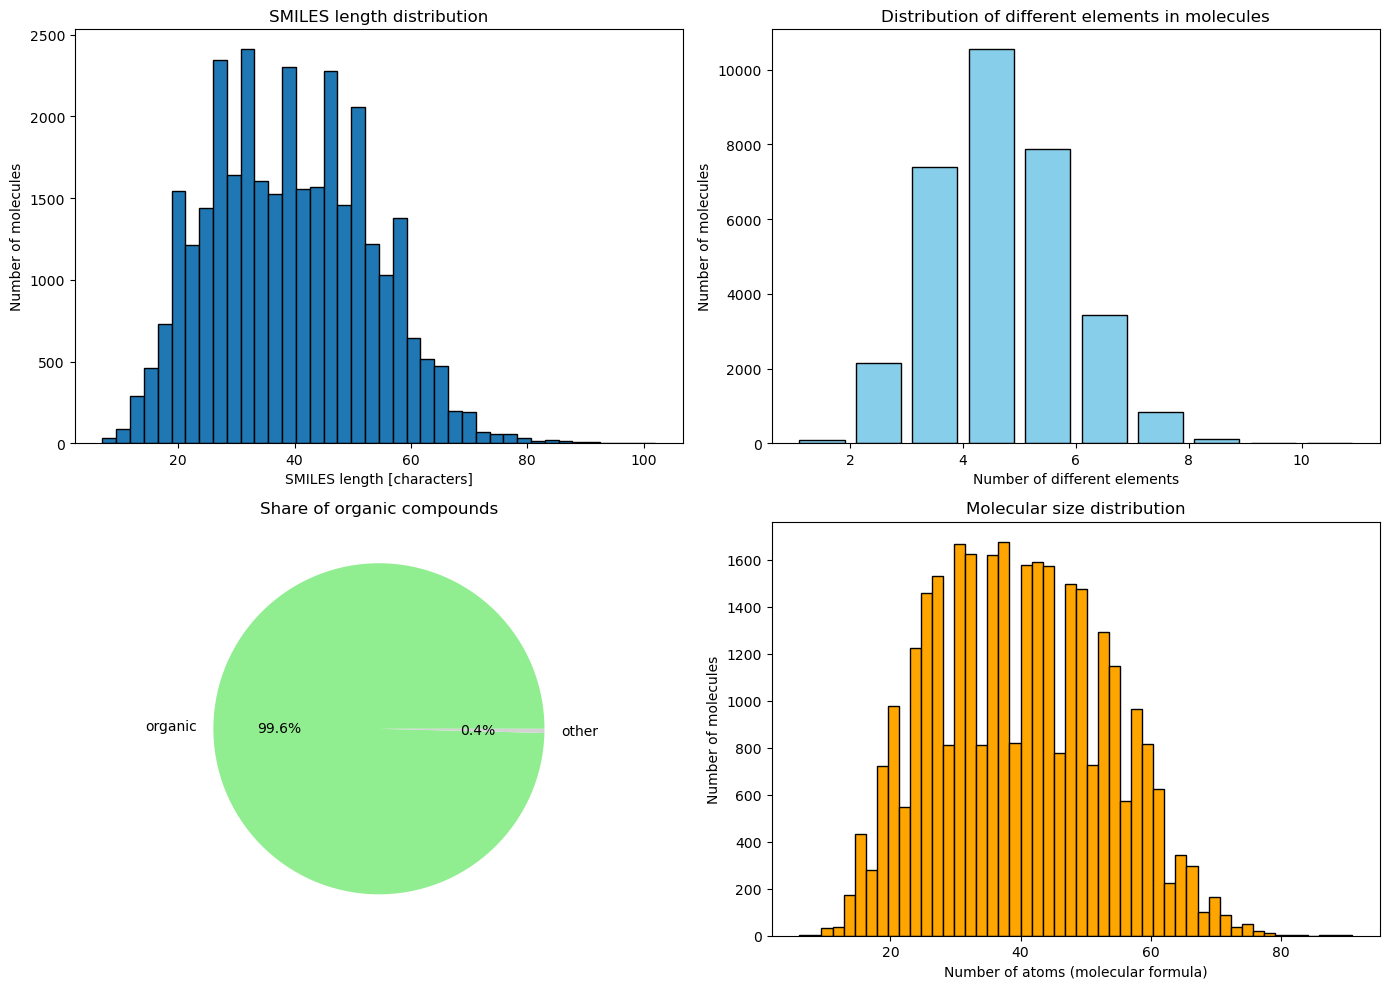

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
(ax1, ax2), (ax3, ax4) = axes

n_molecules = len(data)

# 1. SMILES length histogram
ax1.hist(data["smiles_len"], bins=40, edgecolor="black")
ax1.set_xlabel("SMILES length [characters]")
ax1.set_ylabel("Number of molecules")
ax1.set_title(f"SMILES length distribution")

# 2. Histogram of number of elements
ax2.hist(
    data["n_elements"].dropna(),
    bins=range(1, 12),
    rwidth=0.8,
    color="skyblue",
    edgecolor="black"
)
ax2.set_xlabel("Number of different elements")
ax2.set_ylabel("Number of molecules")
ax2.set_title(f"Distribution of different elements in molecules")

# 3. Pie chart organic / other
counts = data["is_organic"].value_counts()
ax3.pie(
    counts,
    labels=["organic", "other"],
    autopct="%.1f%%",
    colors=["lightgreen", "lightgray"]
)
ax3.set_title("Share of organic compounds")

# 4. Histogram of the number of atoms
def atom_count(formula):
    nums = re.findall(r"\d+", str(formula))
    return sum(map(int, nums)) if nums else None

data["atom_count"] = data["molecular_formula"].map(atom_count)

ax4.hist(
    data["atom_count"].dropna(),
    bins=50,
    color="orange",
    edgecolor="black"
)
ax4.set_xlabel("Number of atoms (molecular formula)")
ax4.set_ylabel("Number of molecules")
ax4.set_title("Molecular size distribution")

plt.tight_layout()
plt.savefig("all_plots_combined.png", dpi=150)
plt.show()

**SMILES length distribution (top-left).**

Most molecules contain 30–50 characters in their SMILES representation.
The distribution is unimodal with a long but sparse tail that extends beyond 80 characters.

**Number of different elements (top-right).**

The majority of molecules contain 4–6 unique chemical elements.
Structures with more than eight elements appear only occasionally, indicating limited elemental diversity.

**Share of organic compounds (bottom-left).**

The dataset is overwhelmingly organic: 99.6% of molecules include at least one carbon atom.
Non-organic structures form only a very small fraction.

**Molecular size distribution (bottom-right).**

Based on atomic counts extracted from molecular formulas, most molecules contain 25–50 atoms.
The distribution is smooth and unimodal, characteristic of small to medium organic molecules.

### 1.3 Hydrogen distribution in the dataset:

Terminology:

• chemical compound = recipe (definition of a substance)

• molecule = one instance of a recipe (one physical object composed of atoms)

In [6]:
# Function counting how many hydrogen atoms a molecule has,
# based on its molecular formula (e.g., "C15H12BrFN4")
def count_h_from_formula(formula):

    # check if the value is a string
    if not isinstance(formula, str):
        return 0

    # search for "H", optionally followed by digits ("H", "H2", "H12", ...)
    m = re.search(r'H(\d*)', formula)

    # if no hydrogen fragment found → 0
    if m is None:
        return 0

    # digits after "H" (empty string if no number)
    num_str = m.group(1)

    # if nothing after "H" → exactly 1 hydrogen atom
    if num_str == "":
        return 1

    # convert the number to int (e.g. "12" → 12)
    return int(num_str)

In [7]:
# Dictionary counting how many molecules have a given number of H atoms
# e.g. {12: 8421, 10: 7900, 8: 6540, 15: 3000, 1: 120}
h_distribution = Counter()

# Counter of all molecules
total_molecules = 0

# Iterate over all .parquet files
for p in paths:
    # load only the "molecular_formula" column (RAM-efficient)
    df = pd.read_parquet(p, columns=["molecular_formula"])
    # debug info for the file (optional)
    # print(os.path.basename(p), "->", len(df), "rows")

    # iterate over all formulas in this file
    for formula in df["molecular_formula"]:
        # count hydrogen atoms, e.g. C15H12N2O2 -> 12
        h_count = count_h_from_formula(formula)
        # update distribution, e.g. if H=12 → increment h_distribution[12]
        h_distribution[h_count] += 1
        # increment total molecule count
        total_molecules += 1

    del df  # free memory

print("\nTotal number of molecules:", total_molecules)
print("Number of distinct H-count values:", len(h_distribution))

# sorted distribution
print("\nDistribution of hydrogen atom counts:")
for h, count in sorted(h_distribution.items()):
    print(f"H = {h:3d} -> {count} molecules")

# most frequent H-counts
print("\nMost common hydrogen atom counts:")
for h, count in h_distribution.most_common(10):
    print(f"H = {h:3d} -> {count} molecules")


Total number of molecules: 794403
Number of distinct H-count values: 64

Distribution of hydrogen atom counts:
H =   1 -> 16 molecules
H =   2 -> 41 molecules
H =   3 -> 706 molecules
H =   4 -> 2242 molecules
H =   5 -> 5887 molecules
H =   6 -> 10159 molecules
H =   7 -> 14728 molecules
H =   8 -> 19858 molecules
H =   9 -> 24940 molecules
H =  10 -> 30000 molecules
H =  11 -> 32982 molecules
H =  12 -> 37758 molecules
H =  13 -> 38912 molecules
H =  14 -> 42241 molecules
H =  15 -> 40680 molecules
H =  16 -> 42861 molecules
H =  17 -> 40471 molecules
H =  18 -> 42178 molecules
H =  19 -> 38987 molecules
H =  20 -> 39120 molecules
H =  21 -> 35819 molecules
H =  22 -> 35015 molecules
H =  23 -> 31162 molecules
H =  24 -> 29343 molecules
H =  25 -> 25474 molecules
H =  26 -> 23594 molecules
H =  27 -> 19378 molecules
H =  28 -> 17698 molecules
H =  29 -> 14106 molecules
H =  30 -> 12475 molecules
H =  31 -> 9106 molecules
H =  32 -> 8420 molecules
H =  33 -> 5964 molecules
H =  34 ->

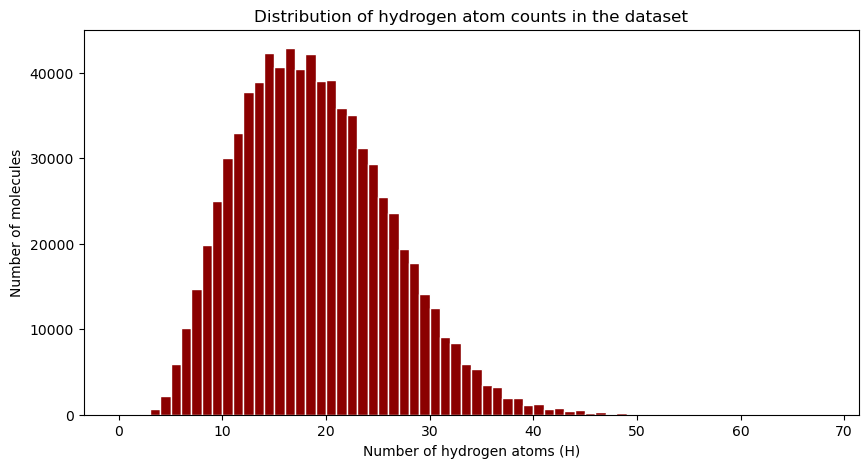

In [8]:
# Convert the Counter into a long list of H-values
# Takes the distribution (value -> frequency)
# and expands it into a list where each H-count appears 'freq' times
h_values = []
for h_count, freq in h_distribution.items():
    h_values += [h_count] * freq   # e.g. if h_count=12, freq=3 → adds [12, 12, 12]

plt.figure(figsize=(10, 5))

# +2 because histogram bins need an upper boundary,
# and range() does not include its endpoint
plt.hist(
    h_values,
    bins=range(0, max(h_values) + 2),
    edgecolor='white',
    color='darkred'
)

plt.xlabel("Number of hydrogen atoms (H)")
plt.ylabel("Number of molecules")
plt.title("Distribution of hydrogen atom counts in the dataset")
plt.show()

The histogram shows the distribution of hydrogen atom counts across all molecules in the dataset.
The values form a smooth, unimodal distribution centered around 14–20 hydrogen atoms (most molecules fall in this range).
Counts below 5 and above 40 are relatively rare, and only a handful of molecules contain more than 50 hydrogens.
This pattern reflects typical sizes of small-to-medium organic molecules present in the dataset.

### 1.4 Distribution of organic elements in dataset

In [9]:
def element_distribution_from_dataset(paths, element):
    """
    Compute the distribution of 'element' atom counts over the whole dataset.

    paths   : list of .parquet file paths
    element : chemical symbol, e.g. "H", "C", "N", "O", "S", "Cl", "Br", "I", "P"

    Returns:
        distribution   : Counter {n_atoms_of_element -> number_of_molecules}
        total_molecules: total number of molecules processed
    """

    distribution = Counter()
    total_molecules = 0

    # precompile regex: element, optionally followed by digits
    # works for mono- and bi-letter symbols, e.g. "H", "S", "Cl", "Br"
    pattern = re.compile(rf"{re.escape(element)}(\d*)")

    for p in paths:
        # load only molecular formulas (RAM-efficient)
        df = pd.read_parquet(p, columns=["molecular_formula"])

        for formula in df["molecular_formula"]:
            if not isinstance(formula, str):
                count = 0
            else:
                m = pattern.search(formula)
                if m is None:
                    count = 0
                else:
                    num_str = m.group(1)
                    count = 1 if num_str == "" else int(num_str)

            distribution[count] += 1
            total_molecules += 1

        del df  # free memory
        
        molecules_with_element = total_molecules - distribution.get(0, 0)
        # percentage of dataset that contains this element
        percentage = round(100 * molecules_with_element / total_molecules, 2)

    return distribution, total_molecules, percentage

In [10]:
def plot_element_histogram(distribution, percentage, element, ax, color):
    """
    Draws a histogram of atom counts for a given chemical element
    directly on the provided matplotlib axis.
    """
    # Expand distribution → long list
    values = []
    for count, freq in distribution.items():
        values += [count] * freq

    ax.hist(
        values,
        bins=range(1, max(values) + 2), # no zero bin (only molecules with at least 1 atom)
        edgecolor="white",
        color=color
    )

    ax.set_xlabel(f"Number of {element} atoms")
    ax.set_ylabel("Number of molecules")
    ax.set_title(f"{element} atom count distribution ({percentage}% of molecules)")

In [11]:
# 1. Hydrogen
h_distribution, total_molecules, h_percentage = element_distribution_from_dataset(paths, "H")

# 2. Carbon
c_distribution, total_molecules, c_percentage = element_distribution_from_dataset(paths, "C")

# 3. Nitrogen
n_distribution, total_molecules, n_percentage = element_distribution_from_dataset(paths, "N")

# 4. Oxygen
o_distribution, total_molecules, o_percentage = element_distribution_from_dataset(paths, "O")

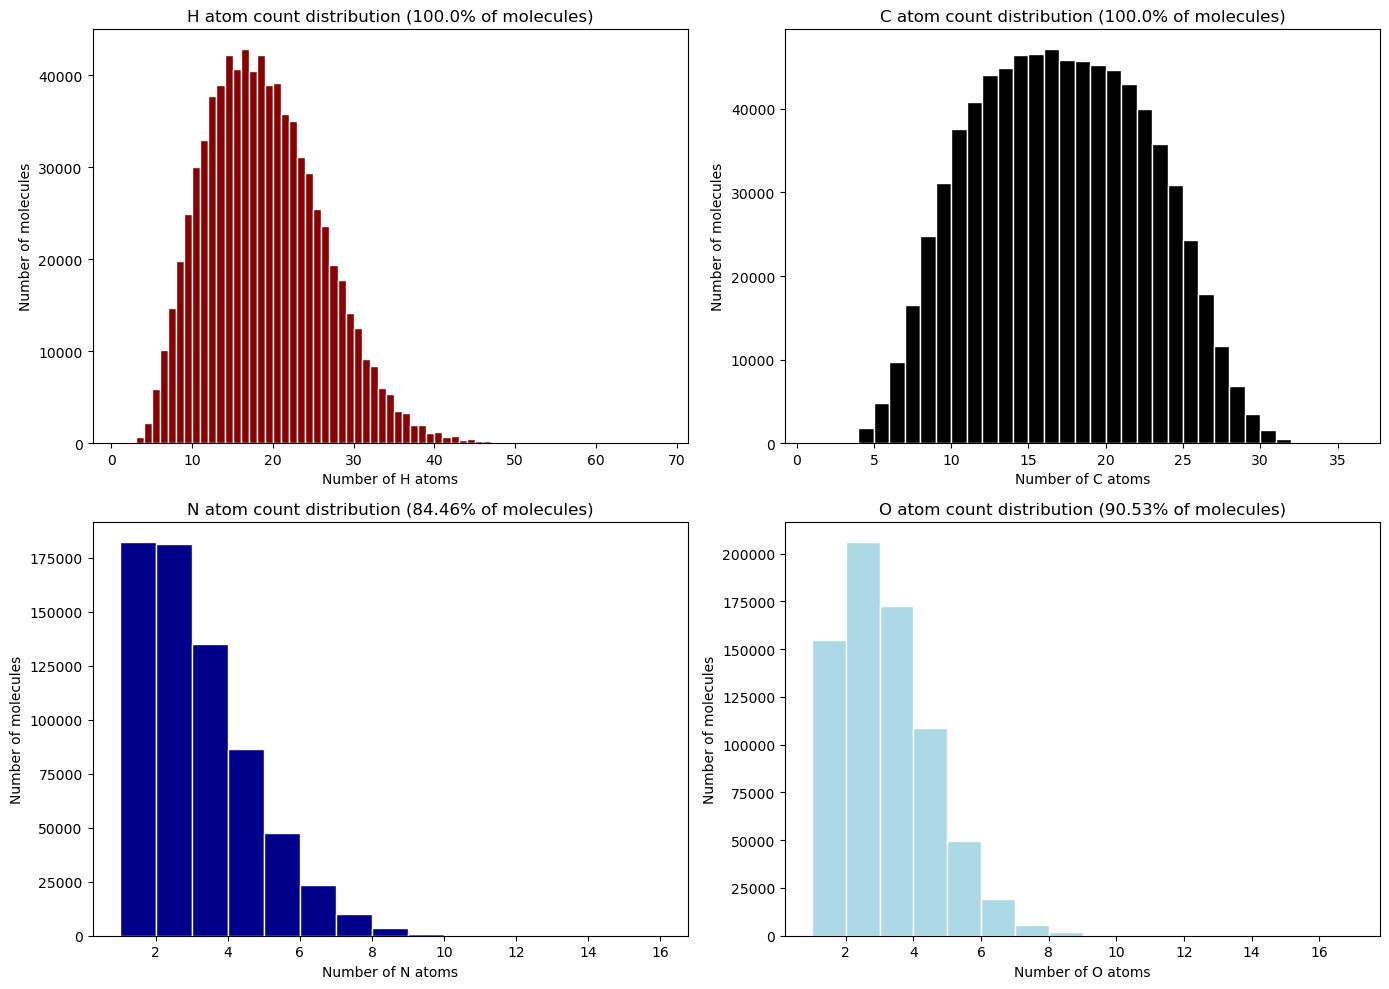

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
(ax1, ax2), (ax3, ax4) = axes

plot_element_histogram(h_distribution, h_percentage, "H", ax1, "darkred")
plot_element_histogram(c_distribution, c_percentage, "C", ax2, "black")
plot_element_histogram(n_distribution, n_percentage, "N", ax3, "darkblue")
plot_element_histogram(o_distribution, o_percentage, "O", ax4, "lightblue")

plt.tight_layout()
plt.show()

**Hydrogen atom count distribution (top-left).**

Hydrogen atoms are present in all molecules, with a dominant range of roughly 10–25 H atoms.
The distribution is smooth and unimodal, with a long tail extending toward larger molecules containing 40+ hydrogens.

**Carbon atom count distribution (top-right).**

All molecules contain carbon. Most structures fall between 12 and 22 carbon atoms, forming a near-symmetric bell-shaped distribution.
This pattern is typical for small and medium-sized organic molecules.

**Nitrogen atom count distribution (bottom-left).**

Approximately 84% of molecules contain at least one nitrogen atom.
Most nitrogen-containing molecules include 1–4 N atoms, with higher counts occurring rarely.
The distribution is right-skewed, reflecting the sporadic presence of heavily nitrogenated structures.

**Oxygen atom count distribution (bottom-right).**

Oxygen appears in about 90% of molecules, most commonly in quantities between 1 and 4 atoms.
The distribution decays smoothly as the O-count increases, indicating that oxygen-bearing functional groups (e.g., alcohols, carbonyls, esters) are widespread but not excessively repeated.

### 1.5 Distribution of other major elements in dataset

In [13]:
# 5. Sulfur
s_distribution, total_molecules, s_percentage = element_distribution_from_dataset(paths, "S")

# 7. Fluorine
f_distribution, total_molecules, f_percentage = element_distribution_from_dataset(paths, "F")

# 6. Chlorine
cl_distribution, total_molecules, cl_percentage = element_distribution_from_dataset(paths, "Cl")

# 8. Bromine
br_distribution, total_molecules, br_percentage = element_distribution_from_dataset(paths, "Br")

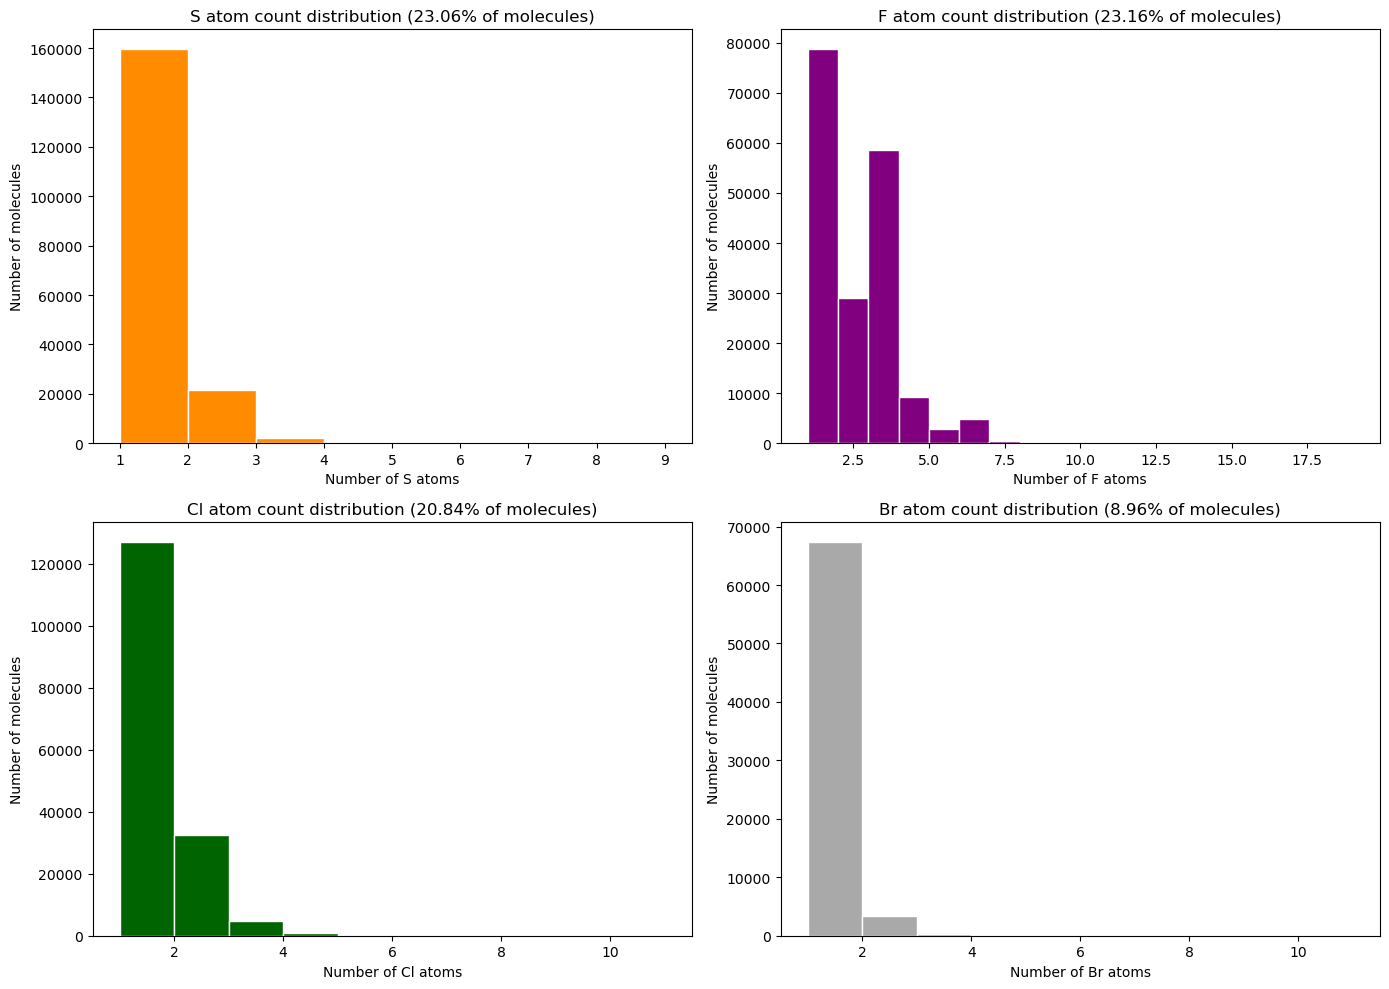

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
(ax1, ax2), (ax3, ax4) = axes

plot_element_histogram(s_distribution, s_percentage, "S", ax1, "darkorange")
plot_element_histogram(f_distribution, f_percentage, "F", ax2, "purple")
plot_element_histogram(cl_distribution, cl_percentage, "Cl", ax3, "darkgreen")
plot_element_histogram(br_distribution, br_percentage, "Br", ax4, "darkgray")

plt.tight_layout()
plt.show()

**Sulfur atom count distribution (top-left).**

Sulfur appears in about 23% of molecules, most commonly as a single atom.
Structures containing two or more sulfur atoms are increasingly rare, and molecules with more than three sulfur atoms are exceptional.

**Fluorine atom count distribution (top-right).**

Fluorine is present in roughly 23% of molecules.
Most fluorinated molecules contain 1–3 fluorine atoms, while higher F-counts occur only sporadically, reflecting targeted fluorination rather than dense substitution.

**Chlorine atom count distribution (bottom-left).**

Chlorine appears in about 21% of molecules.
The majority of chlorinated structures contain exactly one chlorine, with two- or three-chlorine variants less common and heavier halogenation almost absent.

**Bromine atom count distribution (bottom-right).**

Bromine is the least frequent of the shown halogens, present in ~9% of molecules.
Nearly all brominated compounds contain exactly one bromine atom, and molecules with two or more bromine atoms form only a very small tail of the distribution.

### 1.6 Spectral NMR image

The dataset includes digital ¹³C NMR spectra stored as raw intensity arrays. Each spectrum is represented as a list of intensity values. The x-axis corresponds to the sample index (the ppm scale is not provided), and the y-axis shows the signal intensity. This allows visualization of the general spectral shape even without calibrated chemical shift values.

SMILES: O=C1Nc2cc(C(F)(F)F)c(Cl)cc2C1(O)c1ccccc1OC(F)(F)F


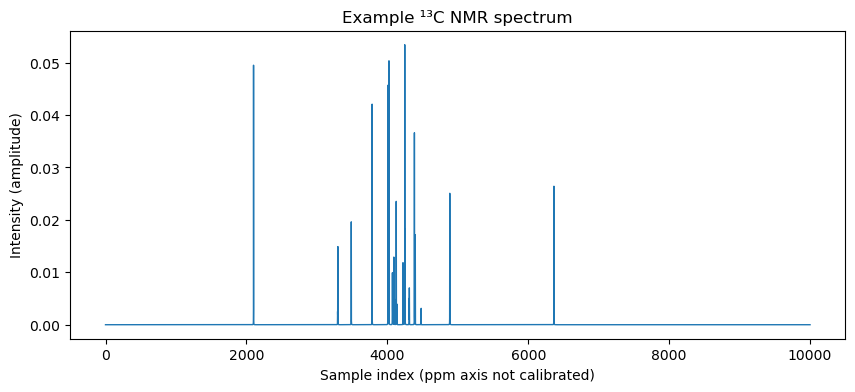

In [15]:
print("SMILES:", data["smiles"][0])

# TBD: Osobny dataset z obrazami spektrów NMR (uzupelnienie do SMILES i SELFIES)
plt.figure(figsize=(10,4))
plt.plot(data["c_nmr_spectra"][0], linewidth=1) # NMR spectrum of the first molecule in dataset
plt.title("Example ¹³C NMR spectrum")
plt.xlabel("Sample index (ppm axis not calibrated)")
plt.ylabel("Intensity (amplitude)")
plt.show()

The spectrum shows several well-defined peaks as well as long flat regions where no carbon signal is detected. The overall shape indicates that the dataset provides full digital spectra with consistent point density across molecules, even though the chemical shift scale is not available.

SMILES: O=C1Nc2cc(C(F)(F)F)c(Cl)cc2C1(O)c1ccccc1OC(F)(F)F
SMILES: CC(C)(C)OC(=O)N1CCN(C2CCC2)CC1
SMILES: COc1ccc(-c2n[nH]c3ncnc(N)c23)cc1F
SMILES: CCN1C[C@H](C)n2c(c(OC)c3c(=O)n(Cc4ccc(F)c(Cl)c4)nc(N)c32)C1=O
SMILES: C=C(C)C(CC(=O)OCC)c1ccc(O)cc1


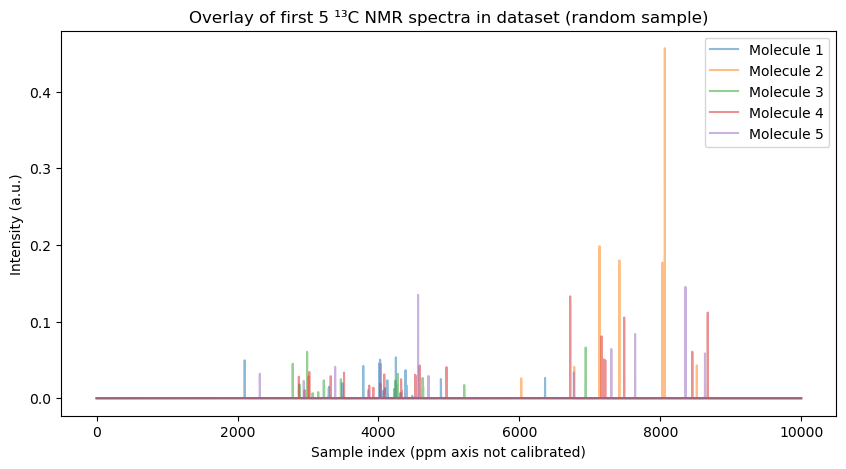

In [16]:
plt.figure(figsize=(10,5))

for i in range(5):
    smiles = data["smiles"][i]
    print("SMILES:", smiles)
    plt.plot(
        data["c_nmr_spectra"][i], 
        alpha=0.5, 
        label=f"Molecule {i+1}"
    )

plt.title("Overlay of first 5 ¹³C NMR spectra in dataset (random sample)")
plt.xlabel("Sample index (ppm axis not calibrated)")
plt.ylabel("Intensity (a.u.)")
plt.legend()
plt.show()

## 2. Conversion: SMILES -> SELFIES -> CSV (streaming across all files)
New, lighter text dataset

In [17]:
# Przykładowa konwersja SMILES -> SELFIES
smiles = list(data['smiles'])

for i in range(5):
    selfie = sf.encoder(smiles[i])
    print(selfie)

[O][=C][N][C][=C][C][Branch1][=Branch2][C][Branch1][C][F][Branch1][C][F][F][=C][Branch1][C][Cl][C][=C][Ring1][O][C][Ring1][=C][Branch1][C][O][C][=C][C][=C][C][=C][Ring1][=Branch1][O][C][Branch1][C][F][Branch1][C][F][F]
[C][C][Branch1][C][C][Branch1][C][C][O][C][=Branch1][C][=O][N][C][C][N][Branch1][#Branch1][C][C][C][C][Ring1][Ring2][C][C][Ring1][#Branch2]
[C][O][C][=C][C][=C][Branch1][P][C][=N][NH1][C][=N][C][=N][C][Branch1][C][N][=C][Ring1][#Branch2][Ring1][#Branch1][C][=C][Ring1][S][F]
[C][C][N][C][C@H1][Branch1][C][C][N][C][=Branch2][Ring2][Branch2][=C][Branch1][Ring1][O][C][C][C][=Branch1][C][=O][N][Branch1][S][C][C][=C][C][=C][Branch1][C][F][C][Branch1][C][Cl][=C][Ring1][Branch2][N][=C][Branch1][C][N][C][=Ring1][P][Ring2][Ring1][=Branch1][C][Ring2][Ring1][O][=O]
[C][=C][Branch1][C][C][C][Branch1][=Branch2][C][C][=Branch1][C][=O][O][C][C][C][=C][C][=C][Branch1][C][O][C][=C][Ring1][#Branch1]


In [18]:
###### DON'T RUN THIS CELL UNLESS YOU WANT TO OVERWRITE THE CSV FILE ######
DATA_DIR = "multimodal_spectroscopic_dataset"
OUT_CSV = "smiles_selfies_full.csv"

# Find and sort all .parquet files by numeric chunk index
paths = glob.glob(os.path.join(DATA_DIR, "*.parquet"))
paths = sorted(paths, key=lambda x: int(re.findall(r"(\d+)", x)[-1]))

print("Found files:", len(paths))

# Open the CSV file once and append rows in the loop
with open(OUT_CSV, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["smiles", "selfies"])  # CSV header

    for p in paths:
        # Load only the 'smiles' column to save RAM
        df = pd.read_parquet(p, columns=["smiles"])
        print(os.path.basename(p), "->", len(df), "records")

        for smi in df["smiles"]:
            # Skip missing or invalid SMILES entries
            if not isinstance(smi, str):
                continue
            try:
                # strict=False prevents crashes for unusual or corrupted SMILES
                selfie = sf.encoder(smi, strict=False)
            except Exception:
                selfie = ""  # fallback for invalid SMILES

            writer.writerow([smi, selfie])

        del df  # free memory after each chunk

print("Saved CSV file:", OUT_CSV)

Found files: 245
aligned_chunk_0.parquet -> 3235 records
aligned_chunk_1.parquet -> 3273 records
aligned_chunk_2.parquet -> 3129 records
aligned_chunk_3.parquet -> 3226 records
aligned_chunk_4.parquet -> 3280 records
aligned_chunk_5.parquet -> 3292 records
aligned_chunk_6.parquet -> 3233 records
aligned_chunk_7.parquet -> 3211 records
aligned_chunk_8.parquet -> 3225 records
aligned_chunk_9.parquet -> 3222 records
aligned_chunk_10.parquet -> 3244 records
aligned_chunk_11.parquet -> 3270 records
aligned_chunk_12.parquet -> 3249 records
aligned_chunk_13.parquet -> 3243 records
aligned_chunk_14.parquet -> 3239 records
aligned_chunk_15.parquet -> 3204 records
aligned_chunk_16.parquet -> 3276 records
aligned_chunk_17.parquet -> 3378 records
aligned_chunk_18.parquet -> 3281 records
aligned_chunk_19.parquet -> 3262 records
aligned_chunk_20.parquet -> 3254 records
aligned_chunk_21.parquet -> 3241 records
aligned_chunk_22.parquet -> 3240 records
aligned_chunk_23.parquet -> 3296 records
aligned_c

In [20]:
# Test of CSV file
pd.set_option('display.max_colwidth', None)
df = pd.read_csv("smiles_selfies_full.csv")
df.head() # first 5 records

,smiles,selfies
0,O=S(O)c1cc2c(cc1F)OC(c1ccc(F)cc1F)(c1ccc(F)cc1F)O2,[O][=S][Branch1][C][O][C][=C][C][=C][Branch1][=Branch1][C][=C][Ring1][=Branch1][F][O][C][Branch1][=N][C][=C][C][=C][Branch1][C][F][C][=C][Ring1][#Branch1][F][Branch1][=N][C][=C][C][=C][Branch1][C][F][C][=C][Ring1][#Branch1][F][O][Ring2][Ring1][Branch2]
1,CN(C)Cc1cccc(C2Nc3cccc4c(=O)[nH]nc(c34)C2c2ccccc2)c1,[C][N][Branch1][C][C][C][C][=C][C][=C][C][Branch2][Ring1][P][C][N][C][=C][C][=C][C][C][=Branch1][C][=O][NH1][N][=C][Branch1][=Branch1][C][Ring1][O][=Ring1][#Branch1][C][Ring1][=C][C][=C][C][=C][C][=C][Ring1][=Branch1][=C][Ring2][Ring1][#Branch2]
2,O=C(N[C@@H](CO)c1nc2cc(Cl)ccc2[nH]1)c1ccc(C(=O)N2CC=CC2)c(Br)c1,[O][=C][Branch2][Ring1][#Branch1][N][C@@H1][Branch1][Ring1][C][O][C][=N][C][=C][C][Branch1][C][Cl][=C][C][=C][Ring1][#Branch1][NH1][Ring1][#Branch2][C][=C][C][=C][Branch1][N][C][=Branch1][C][=O][N][C][C][=C][C][Ring1][Branch1][C][Branch1][C][Br][=C][Ring1][=C]
3,O=C(Cn1cc(I)cn1)N1CCCc2c1cnn2-c1ccc(F)cc1,[O][=C][Branch1][N][C][N][C][=C][Branch1][C][I][C][=N][Ring1][=Branch1][N][C][C][C][C][=C][Ring1][=Branch1][C][=N][N][Ring1][Branch1][C][=C][C][=C][Branch1][C][F][C][=C][Ring1][#Branch1]
4,Cc1ccc(-c2ccnc(Cl)c2)n1CC(=O)OCc1ccccc1,[C][C][=C][C][=C][Branch1][N][C][=C][C][=N][C][Branch1][C][Cl][=C][Ring1][#Branch1][N][Ring1][N][C][C][=Branch1][C][=O][O][C][C][=C][C][=C][C][=C][Ring1][=Branch1]


## 3. SELFIES tokenization

Special tokens used in the sequential model:

| Token     | Meaning                |
|-----------|-------------------------------|
| &lt;sos&gt; | start of sequence         |
| &lt;eos&gt; | end of sequence               |
| &lt;pad&gt; | padding (length alignment) |

An example of tokenization:

[’[C]’, ‘[C]’, ‘[O]’, ‘[Branch1_1]’, ‘[C]’]

After adding special tokens and padding to align the length:


| Token        | Indeks |
|--------------|---------|
| &lt;sos&gt;        | 1       |
| [C]          | 10      |
| [C]          | 10      |
| [O]          | 23      |
| [Branch1_1]  | 41      |
| [C]          | 10      |
| &lt;eos&gt;        | 2       |
| &lt;pad&gt;        | 0       |
| &lt;pad&gt;        | 0       |
| ...          | ...       |

## 4. Searching for functional groups using SMARTS

SMILES -> SMARTS -> vector

### 4.1 Terminology (SMARTS)

SMARTS — a pattern-matching language used to detect structural fragments inside molecules.  
Unlike SMILES (which encodes a specific molecule), SMARTS describes a general rule for matching atoms and bonds.

**Atom expressions** — atoms written using atomic numbers:  
- [#6] carbon  
- [#7] nitrogen  
- [#8] oxygen  
- [#16] sulfur  

**Bond expressions** — symbols describing bond types:  
- `-` single  
- `=` double  
- `#` triple  
- `:` aromatic  

**Substructure matching** — RDKit checks whether a molecule contains a fragment that satisfies the SMARTS rule.  

#### Example SMARTS patterns

| Functional group | SMARTS pattern   | Meaning                              |
|------------------|------------------|--------------------------------------|
| Alcohol (OH)     | [OX2H]         | Oxygen with one hydrogen             |
| Ketone           | C(=O)C         | Carbonyl with two carbons            |
| Aldehyde         | C(=O)H         | Carbonyl with hydrogen               |
| Aromatic ring    | c1ccccc1       | Six-membered aromatic ring           |
| Carboxylic acid  | C(=O)[OX2H1]   | COOH group                           |
| Amine            | [NX3;H2,H1,H0] | Trivalent nitrogen                   |

1. Original SMILES:
CN(C)Cc1cccc(C2Nc3cccc4c(=O)[nH]nc(c34)C2c2ccccc2)c1

2. Converted Mol object:

3. Converted SMARTS:
[#6]-[#7](-[#6])-[#6]-[#6]1:[#6]:[#6]:[#6]:[#6](-[#6]2-[#7]-[#6]3:[#6]:[#6]:[#6]:[#6]4:[#6](=[#8]):[#7]:[#7]:[#6](:[#6]:3:4)-[#6]-2-[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2):[#6]:1

4. Molecule image to check accuracy:


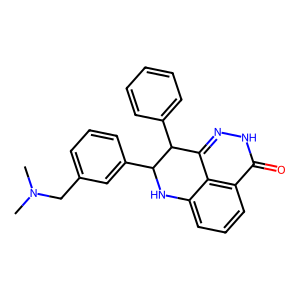

In [114]:
# 1. Read and print first row SMILES from CSV
smiles = df.loc[1, "smiles"]

print("1. Original SMILES:")
print(smiles)

# 2. RDKit conversion: SMILES -> Mol
mol = Chem.MolFromSmiles(smiles)
print("\n2. Converted Mol object:")
print(mol)

# 3. RDKit conversion: Mol -> SMARTS
smarts = Chem.MolToSmarts(mol)

print("\n3. Converted SMARTS:")
print(smarts)

# 4. Display molecule image using RDKit
print("\n4. Molecule image to check accuracy:")
Draw.MolToImage(mol)

The original SMILES string encodes the molecule as a linear text sequence, but it does not explicitly show the underlying graph structure. 

After conversion into an RDKit Mol object, the molecule is represented internally as a network of atoms and bonds with defined connectivity, aromaticity and bond types. 

Converting this Mol into SMARTS produces a fully explicit pattern description in which every atom is annotated with its element and valence state, and all bonds are written out as single, double, aromatic or ring-closure connections. 

This expanded SMARTS form makes the hidden structure of the SMILES clear and is suitable for functional-group pattern matching. 

The generated 2D depiction provides a visual check that RDKit interpreted the original SMILES correctly and that the SMARTS corresponds to the same structure.

### 4.2 Reconstructing Functional Groups from SMILES

In [3]:
SMILES_FUNCTIONAL_GROUP = {

    # ===== hydrocarbons =====
    "alkane":        "CC",              # e.g. ethane
    "alkene":        "C=C",             # e.g. ethene
    "alkyne":        "C#C",             # e.g. ethyne
    "arene":         "CCc1ccccc1",      # e.g. ethyl benzene

    # ===== halogen-containing =====
    "haloalkane":    "CCCl",            # e.g. chloroethane

    # ===== oxygen-containing =====
    "alcohol":           "CCO",                 # e.g. ethanol
    "aldehyde":          "CC=O",               # e.g. ethanal
    "ketone":            "CC(=O)C",            # e.g. propanone
    "carboxylic_acid":   "CC(=O)O",            # e.g. ethanoic acid
    "acid_anhydride":    "CC(=O)OC(=O)C",      # e.g. ethanoic anhydride
    "ester":             "CCOC(=O)C",          # e.g. ethyl ethanoate
    "ether":             "COCC",               # e.g. methoxyethane
    "epoxide":           "C1CO1",              # e.g. ethene oxide

    # ===== nitrogen-containing =====
    "amine":             "CCN",                # e.g. ethanamine
    "amide":             "CC(=O)N",            # e.g. ethanamide
    "nitrate":           "CCO[N+](=O)[O-]",    # e.g. ethyl nitrate
    "nitrite":           "CCON=O",             # e.g. ethyl nitrite (R-ONO)
    "nitrile":           "CC#N",               # e.g. ethanenitrile
    "nitro":             "C[N+](=O)[O-]",      # e.g. nitromethane
    "nitroso":           "CCN=O",              # e.g. nitrosoethane
    "imine":             "CC=N",               # e.g. ethanimine (CH3-CH=NH)
    "imide":             "O=C1NCCC1=O",        # e.g. succinimide
    "azide":             "c1ccccc1N=[N+]=[N-]",# e.g. phenylazide
    "cyanate":           "COC#N",              # e.g. methyl cyanate
    "isocyanate":        "CN=C=O",             # e.g. methyl isocyanate
    "azo_compound":      "CN=NC",              # e.g. azoethane

    # ===== sulfur-containing =====
    "thiol":             "CS",                 # e.g. methanethiol
    "sulfide":           "CSC",                # e.g. dimethyl sulfide
    "disulfide":         "CSSC",               # e.g. dimethyl disulfide
    "sulfoxide":         "CS(=O)C",            # e.g. dimethyl sulfoxide
    "sulfone":           "CS(=O)(=O)C",        # e.g. dimethyl sulfone
    "sulfinic_acid":     "c1ccccc1S(=O)O",     # e.g. benzenesulfinic acid
    "sulfonic_acid":     "c1ccccc1S(=O)(=O)O", # e.g. benzenesulfonic acid
    "sulfonate_ester":   "CS(=O)(=O)OC",       # e.g. methyl methanesulfonate
    "thiocyanate":       "CCSC#N",             # e.g. ethyl thiocyanate
    "isothiocyanate":    "CCN=C=S",            # e.g. ethyl isothiocyanate
    "thial":             "CC=S",               # e.g. ethanethial
    "thioketone":        "CC(=S)C",            # e.g. propanethione (thioacetone)

    # ===== phosphorus-containing =====
    "phosphine":         "CP",                 # e.g. methylphosphane
}

In [4]:
# Example SMILES for each functional group
EXAMPLE_NAMES = {
    # hydrocarbons
    "alkane": "ethane",
    "alkene": "ethene",
    "alkyne": "ethyne",
    "arene": "ethyl benzene",

    # halogen-containing
    "haloalkane": "chloroethane",

    # oxygen-containing
    "alcohol": "ethanol",
    "aldehyde": "ethanal",
    "ketone": "propanone",
    "carboxylic_acid": "ethanoic acid",
    "acid_anhydride": "acetic anhydride",
    "ester": "ethyl ethanoate",
    "ether": "methoxyethane",
    "epoxide": "ethylene oxide",

    # nitrogen-containing
    "amine": "ethanamine",
    "amide": "ethanamide",
    "nitrate": "ethyl nitrate",
    "nitrite": "ethyl nitrite",
    "nitrile": "ethanenitrile",       # CC#N matches ethanenitrile
    "nitro": "nitromethane",
    "nitroso": "nitrosoethane",
    "imine": "ethanimine",
    "imide": "succinimide",
    "azide": "phenyl azide",
    "cyanate": "methyl cyanate",      # COC#N
    "isocyanate": "methyl isocyanate",
    "azo_compound": "azoethane",

    # sulfur-containing
    "thiol": "ethanethiol",
    "sulfide": "dimethyl sulfide",
    "disulfide": "dimethyl disulfide",
    "sulfoxide": "dimethyl sulfoxide",
    "sulfone": "dimethyl sulfone",
    "sulfinic_acid": "benzenesulfinic acid",
    "sulfonic_acid": "benzenesulfonic acid",
    "sulfonate_ester": "methyl methanesulfonate",
    "thiocyanate": "ethyl thiocyanate",
    "isothiocyanate": "ethyl isothiocyanate",
    "thial": "ethanethial",
    "thioketone": "thioacetone",

    # phosphorus-containing
    "phosphine": "methylphosphane",
}

In [5]:
def show_functional_group_grid(smiles_dict, mols_per_row=6, size=(220, 220), show_H=False):
    mols = []
    legends = []

    for name, smi in smiles_dict.items():
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            print(f"Could not parse SMILES for {name}: {smi}")
            continue

        if show_H:
            mol = Chem.AddHs(mol)

        example = EXAMPLE_NAMES.get(name, "?")
        legends.append(f"{name} ({example}): {smi}")

        mols.append(mol)

    img = Draw.MolsToGridImage(
        mols,
        molsPerRow=mols_per_row,
        subImgSize=size,
        legends=legends
    )
    display(img)

#### Visual Grid of Functional-Group Examples Derived from SMILES (Explicit Hydrogens)


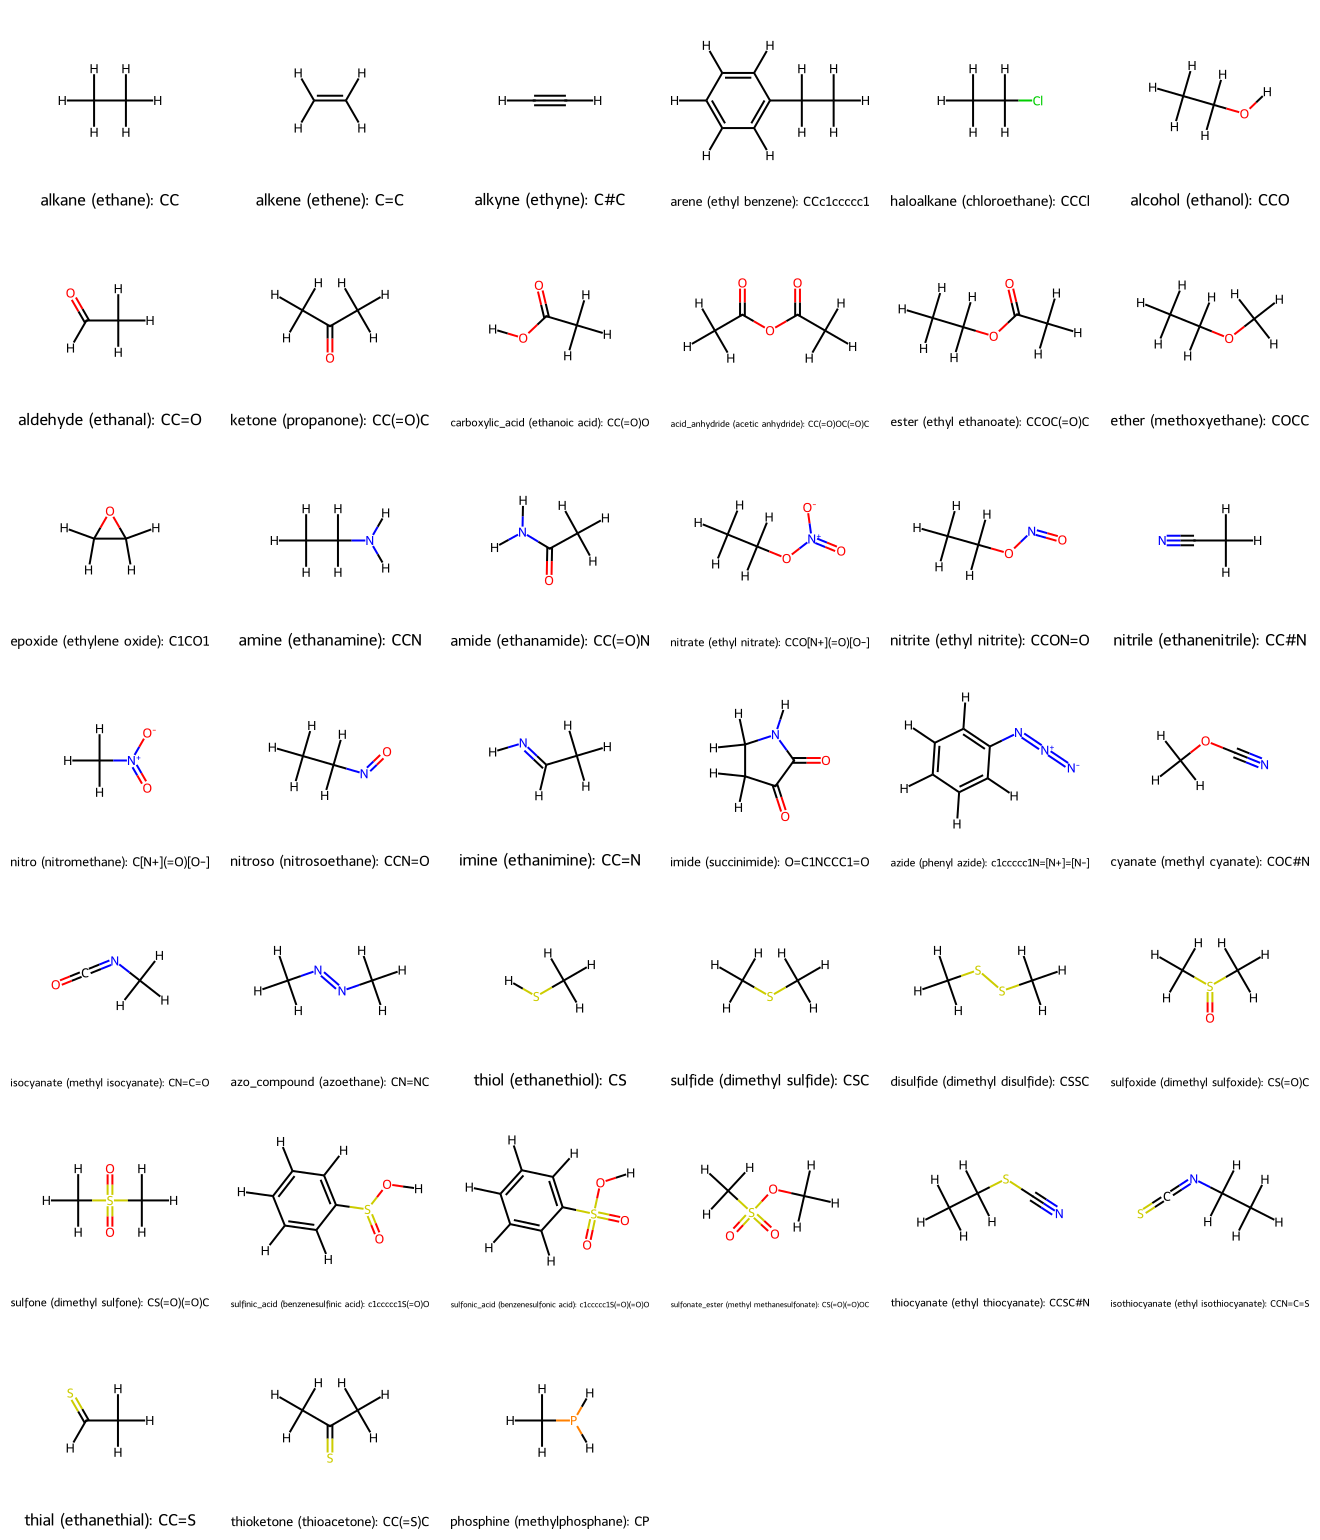

In [6]:
show_functional_group_grid(SMILES_FUNCTIONAL_GROUP, mols_per_row=6, show_H=True)

#### Original reference figure
![Original functional-groups poster](organic_functional_groups.png)

### 4.3 Evaluation of SMARTS-Based Functional Group Detection

In [7]:
SMARTS_FUNCTIONAL_GROUP = {
    # ===== Hydrocarbons =====
    "alkane":           "[CX4][CX4]",           # R–CH2–CH2–R
    "alkene":           "[CX3]=[CX3]",          # R–CH=CH–R
    "alkyne":           "[CX2]#[CX2]",          # R–C≡C–R
    "arene":            "c1ccccc1",             # benzenowy pierścień aromatyczny

    # ===== Halogen-containing =====
    "haloalkane":       "[CX4][F,Cl,Br,I]",     # R–C–X (X = halogen)

    # ===== Oxygen-containing =====
    "alcohol":          "[CX4][OX2H]",          # R–CHx–OH
    "aldehyde":         "[CX3H1](=O)[#6]",      # R–CH=O
    "ketone":           "[CX3](=O)[CX4]",       # R–CO–R'
    "carboxylic_acid":  "C(=O)[OX2H1]",         # R–CO2H
    "acid_anhydride":   "C(=O)OC(=O)",          # R–CO–O–CO–R'
    "ester":            "C(=O)O[#6]",           # R–COOR'
    "ether":            "[CX4][OX2][CX4]",      # R–O–R'
    "epoxide":          "[OX2]1[CH2][CH2]1",    # trójczłonowy pierścień eteru

    # ===== Nitrogen-containing =====
    "amine":            "[NX3;!$(NC=O)]",       # amina, ale nie amid
    "amide":            "C(=O)N",               # R–CONH–
    "nitrate":          "O[N+](=O)[O-]",        # R–ONO2
    "nitrite":          "ON=O",                 # R–ONO
    "nitrile":          "[#6]#N",               # R–C≡N
    "nitro":            "[N+](=O)[O-]",         # –NO2
    "nitroso":          "N=O",                  # –N=O
    "imine":            "[CX3]=[NX2]",          # R–CH=NR'
    "imide":            "C(=O)NCCC(=O)",        # –C(=O)–N–C–C–C(=O)–
    "azide":            "N=[N+]=[N-]",          # –N=N⁺=N⁻
    "cyanate":          "OC#N",                 # R–O–C≡N
    "isocyanate":       "N=C=O",                # R–N=C=O
    "azo_compound":     "[NX2]=[NX2]",          # –N=N–

    # ===== Sulfur-containing =====
    "thiol":            "[SX2H]",               # R–SH
    "sulfide":          "[#16X2][#6]",          # R–S–R'
    "disulfide":        "S-S",                  # R–S–S–R'
    "sulfoxide":        "[#16X3](=O)[#6]",      # R–S(=O)–R'
    "sulfone":          "[#16X4](=O)(=O)[#6]",  # R–S(=O)2–R'
    "sulfinic_acid":    "[#16X3](=O)[OX2H]",    # R–S(=O)–OH
    "sulfonic_acid":    "[#16X4](=O)(=O)[OX2H]",# R–S(=O)2–OH
    "sulfonate_ester":  "[#16X4](=O)(=O)O[#6]", # R–S(=O)2–OR'
    "thiocyanate":      "SC#N",                 # –S–C≡N
    "isothiocyanate":   "N=C=S",                # –N=C=S
    "thial":            "C=S",                  # –CH=S lub –C=S
    "thioketone":       "C(=S)[#6]",            # R–C(=S)–R'

    # ===== Phosphorus-containing =====
    "phosphine":        "P[#6]",                # R–P–H2 / R–P–R'
}

In [8]:
def test_smarts_on_smiles(smarts_dict, example_smiles_dict):
    """
    Check if each SMARTS pattern finds its functional group
    in the corresponding example SMILES.

    smarts_dict        : dict name -> SMARTS pattern (FUNCTIONAL_GROUP_SMARTS)
    example_smiles_dict: dict name -> example SMILES (FUNCTIONAL_GROUP_DRAW_SMILES)
    """
    results = {}

    for name, sma in smarts_dict.items():
        example_smi = example_smiles_dict.get(name, None)

        # if we don't have an example for this group, skip
        if example_smi is None:
            print(f"[SKIP] No example SMILES for group: {name}")
            results[name] = "NO_EXAMPLE"
            continue

        patt = Chem.MolFromSmarts(sma)
        if patt is None:
            print(f"[ERROR] Could not parse SMARTS for {name}: {sma}")
            results[name] = "BAD_SMARTS"
            continue

        mol = Chem.MolFromSmiles(example_smi)
        if mol is None:
            print(f"[ERROR] Could not parse SMILES for {name}: {example_smi}")
            results[name] = "BAD_SMILES"
            continue

        # check substructure match
        matches = mol.GetSubstructMatches(patt)
        if matches:
            print(f"[PASS] {name:20s}  SMARTS: {sma:20s}  SMILES: {example_smi}  (matches: {len(matches)})")
            results[name] = "PASS"
        else:
            print(f"[FAIL] {name:20s}  SMARTS: {sma:20s}  SMILES: {example_smi}  (no match)")
            results[name] = "FAIL"

    return results

In [122]:
test_results = test_smarts_on_smiles(SMARTS_FUNCTIONAL_GROUP, SMILES_FUNCTIONAL_GROUP)

[PASS] alkane                SMARTS: [CX4][CX4]            SMILES: CC  (matches: 1)
[PASS] alkene                SMARTS: [CX3]=[CX3]           SMILES: C=C  (matches: 1)
[PASS] alkyne                SMARTS: [CX2]#[CX2]           SMILES: C#C  (matches: 1)
[PASS] arene                 SMARTS: c1ccccc1              SMILES: CCc1ccccc1  (matches: 1)
[PASS] haloalkane            SMARTS: [CX4][F,Cl,Br,I]      SMILES: CCCl  (matches: 1)
[PASS] alcohol               SMARTS: [CX4][OX2H]           SMILES: CCO  (matches: 1)
[PASS] aldehyde              SMARTS: [CX3H1](=O)[#6]       SMILES: CC=O  (matches: 1)
[PASS] ketone                SMARTS: [CX3](=O)[CX4]        SMILES: CC(=O)C  (matches: 2)
[PASS] carboxylic_acid       SMARTS: C(=O)[OX2H1]          SMILES: CC(=O)O  (matches: 1)
[PASS] acid_anhydride        SMARTS: C(=O)OC(=O)           SMILES: CC(=O)OC(=O)C  (matches: 1)
[PASS] ester                 SMARTS: C(=O)O[#6]            SMILES: CCOC(=O)C  (matches: 1)
[PASS] ether                 SMAR

The test confirms that all major functional-group definitions behave as expected and that each example molecule is correctly matched by its corresponding SMARTS pattern. This shows that the SMARTS dictionary is syntactically valid, chemically meaningful, and suitable for reliable automated functional-group detection across the dataset.

### 4.4. Constructing Functional Group Vectors 
#### Calculating occurrence counts for functional groups in each molecule.

In [10]:
# 1. Read CSV file with SMILES and SELFIES
df = pd.read_csv("smiles_selfies_full.csv", names=["smiles", "selfies"], header=0)

# 2. SMARTS_FUNCTIONAL_GROUP: dict name -> SMARTS string (defined earlier)

# 3. Compile SMARTS strings to RDKit Mol patterns
SMARTS_PATTERNS = {}
for name, smarts in SMARTS_FUNCTIONAL_GROUP.items():
    pattern = Chem.MolFromSmarts(smarts)
    if pattern is None:
        print(f"Warning: could not parse SMARTS for {name}: {smarts}")
        continue
    SMARTS_PATTERNS[name] = pattern


def fg_vec_from_smiles(smiles):
    """
    For a single molecule (SMILES) return a dict:
    group_name -> 0/1 indicating presence of that functional group.
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        # RDKit could not interpret this SMILES → return zeros for all groups
        return {name: 0 for name in SMARTS_PATTERNS.keys()}

    result = {}
    for name, pattern in SMARTS_PATTERNS.items():
        result[name] = len(mol.GetSubstructMatches(pattern))
    return result


# 4. Apply to the entire SMILES column
fg_dicts = df["smiles"].apply(fg_vec_from_smiles)

# 5. Turn list of dicts into DataFrame with columns with counter for each functional group
fg_df = pd.DataFrame(list(fg_dicts))

# 6. Concatenate original SMILES/SELFIES with functional-group indicators
df_with_fg = pd.concat([df, fg_df], axis=1)

# 7. Preview
df_with_fg.head()

,smiles,selfies,alkane,alkene,alkyne,arene,haloalkane,alcohol,aldehyde,ketone,...,sulfoxide,sulfone,sulfinic_acid,sulfonic_acid,sulfonate_ester,thiocyanate,isothiocyanate,thial,thioketone,phosphine
0,O=S(O)c1cc2c(cc1F)OC(c1ccc(F)cc1F)(c1ccc(F)cc1...,[O][=S][Branch1][C][O][C][=C][C][=C][Branch1][...,0,0,0,3,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
1,CN(C)Cc1cccc(C2Nc3cccc4c(=O)[nH]nc(c34)C2c2ccc...,[C][N][Branch1][C][C][C][C][=C][C][=C][C][Bran...,1,0,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,O=C(N[C@@H](CO)c1nc2cc(Cl)ccc2[nH]1)c1ccc(C(=O...,[O][=C][Branch2][Ring1][#Branch1][N][C@@H1][Br...,1,1,0,2,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,O=C(Cn1cc(I)cn1)N1CCCc2c1cnn2-c1ccc(F)cc1,[O][=C][Branch1][N][C][N][C][=C][Branch1][C][I...,2,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,Cc1ccc(-c2ccnc(Cl)c2)n1CC(=O)OCc1ccccc1,[C][C][=C][C][=C][Branch1][N][C][=C][C][=N][C]...,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


#### Saving Results to .parquet Format (for Use in Future Training)

In [11]:
# 8. Save SELFIES + functional groups as a Parquet file
OUTPUT = "selfies_with_functional_groups.parquet"

# wybieramy tylko kolumny potrzebne w treningu VAE
cols_to_save = ["selfies"] + list(fg_df.columns)

df_with_fg[cols_to_save].to_parquet(OUTPUT, index=False)

print("Saved:", OUTPUT)

Saved: selfies_with_functional_groups.parquet


# TBD: Benchmarki dla modelu.

Jakie fizyczne aleznosci potencjalnie dałoby się wyizolować z tych latentow